In [4]:
%load_ext autoreload
%autoreload 2

# Hyperdt install

In [2]:
# %%bash
# which python
# cd ~
# git clone https://github.com/qc2321/hyperDT # Quentin's updated version of hyperDT
# cd hyperDT
# pip install -e .

In [74]:
# %%bash
# pip install geomstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 101.9 MB/s eta 0:00:00 0:00:01



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


# HyperDT benchmark - Gaussian mixtures

In [65]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import embedders

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.forest import ProductSpaceRF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


1.0
0.995


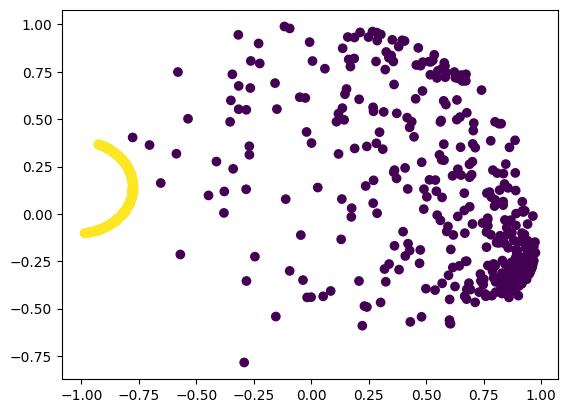

In [70]:
# Basic structure: let's do H2

signature = [(-1, 2)]
pm = embedders.manifolds.ProductManifold(signature=signature)

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, seed=0, cov_scale_means=1.0, cov_scale_points=1.0)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# hyperDT
hdt = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=1)
hdt.fit(X_train, y_train)
print(hdt.score(X_test, y_test))

# sklearn
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

# Also let's visualize the points
X_poincare = embedders.visualization.hyperboloid_to_poincare(X)
plt.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y)

In [68]:
from tqdm.notebook import tqdm
from hyperdt.product_space_DT import ProductSpaceDT
from hyperdt.forest import ProductSpaceRF
from sklearn.metrics import accuracy_score, f1_score

results = []

CURVATURES = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
DIM = 2
N_SAMPLES = 20
N_CLASSES = 10

my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
for i, K in enumerate(CURVATURES):
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed + N_SAMPLES * i
        pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)])

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm, seed=seed, num_classes=N_CLASSES, cov_scale_means=1.0, cov_scale_points=1.0
        )
        X = X.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Evaluate sklearn
        dt = DecisionTreeClassifier(max_depth=3)
        dt.fit(X_train, y_train)
        # dt_acc = accuracy_score(dt.predict(X_test), y_test)
        dt_acc = f1_score(dt.predict(X_test), y_test, average="micro")

        rf = RandomForestClassifier(n_estimators=12, max_depth=3)
        rf.fit(X_train, y_train)
        rf_acc = f1_score(rf.predict(X_test), y_test, average="micro")

        # Evaluate ProductDT
        psdt = ProductSpaceDT(signature=[(x[1], x[0]) for x in pm.signature], max_depth=3)
        if K == 0:
            X_train = np.hstack([np.ones(shape=(X_train.shape[0], 1)), X_train])
            X_test = np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
        psdt.fit(X_train, y_train)
        # psdt_acc = accuracy_score(psdt.predict(X_test), y_test)
        psdt_acc = f1_score(psdt.predict(X_test), y_test, average="micro")

        psrf = ProductSpaceRF(signature=[(x[1], x[0]) for x in pm.signature], n_estimators=12, max_depth=3)
        psrf.fit(X_train, y_train)
        psrf_acc = f1_score(psrf.predict(X_test), y_test, average="micro")

        results.append(
            {
                "curvature": K,
                "seed": seed,
                "psdt_acc": psdt_acc,
                "dt_acc": dt_acc,
                "psrf_acc": psrf_acc,
                "rf_acc": rf_acc,
            }
        )

        my_tqdm.update(1)

results = pd.DataFrame(results)

  0%|          | 0/180 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/teamspace/studios/this_studio/hyperDT/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2
/teamspace/studios/this_studio/hyperDT/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/teamspace/studios/this_studio/hyperDT/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2
/teamspace/studios/this_studio/hyperDT/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqr

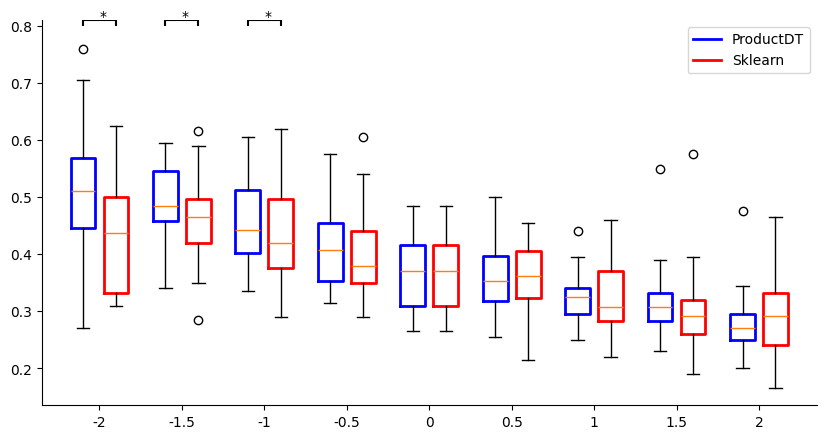

In [77]:
# Let's see the values: barplot with statistical significance annotations

from scipy.stats import ttest_rel

# psdt_means, dt_means, psdt_stds, dt_stds, p_vals = [], [], [], [], []
psdt_scores_by_curvature, dt_scores_by_curvature, p_vals = [], [], []
psrf_scores_by_curvature, rf_scores_by_curvature, p_vals2 = [], [], []
for K in CURVATURES:
    res_K = results[results["curvature"] == K]
    psdt_scores_by_curvature.append(res_K["psdt_acc"])
    dt_scores_by_curvature.append(res_K["dt_acc"])
    p_vals.append(ttest_rel(res_K["psdt_acc"], res_K["dt_acc"]).pvalue)

    # RF stuff
    psrf_scores_by_curvature.append(res_K["psrf_acc"])
    rf_scores_by_curvature.append(res_K["rf_acc"])
    p_vals2.append(ttest_rel(res_K["psrf_acc"], res_K["rf_acc"]).pvalue)


plt.figure(figsize=(10, 5))
x_vals = np.arange(len(CURVATURES))
bp1 = plt.boxplot(
    psdt_scores_by_curvature,
    positions=x_vals - 0.2,
    widths=0.3,
    boxprops=dict(color="blue", linewidth=2),
)
bp2 = plt.boxplot(
    dt_scores_by_curvature,
    positions=x_vals + 0.2,
    widths=0.3,
    boxprops=dict(color="red", linewidth=2),
)

# Add asterisks
ymin, ymax = plt.gca().get_ylim()
for x, p_val in zip(x_vals, p_vals):
    if p_val < 0.05:
        plt.text(x, ymax + 0.02, "*", color="black")
        plt.hlines(ymax + 0.02, x - 0.2, x + 0.2, color="black")
        plt.vlines(x - 0.2, ymax + 0.01, ymax + 0.02, color="black")
        plt.vlines(x + 0.2, ymax + 0.01, ymax + 0.02, color="black")

# Fix y-lim and remove top/right spines
plt.ylim(ymin, ymax + 0.02)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Set x-ticks
plt.xticks(x_vals, CURVATURES)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["ProductDT", "Sklearn"])

# Transparent
plt.show()

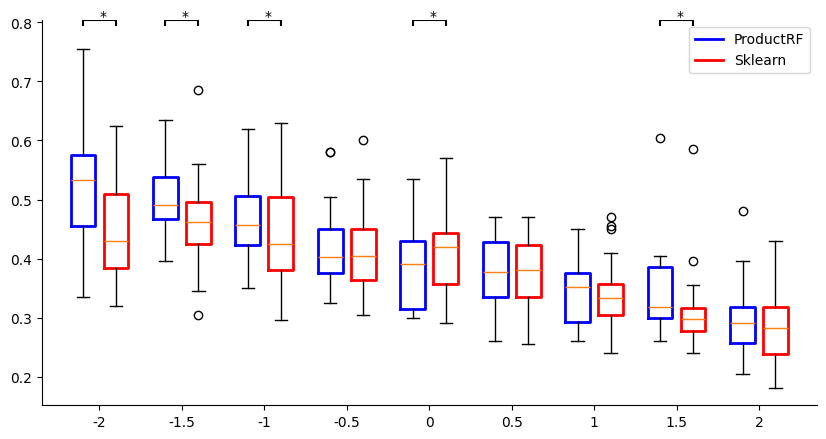

In [78]:
# Version with RF classifiers

plt.figure(figsize=(10, 5))
x_vals = np.arange(len(CURVATURES))
bp1 = plt.boxplot(
    psrf_scores_by_curvature,
    positions=x_vals - 0.2,
    widths=0.3,
    boxprops=dict(color="blue", linewidth=2),
)
bp2 = plt.boxplot(
    rf_scores_by_curvature,
    positions=x_vals + 0.2,
    widths=0.3,
    boxprops=dict(color="red", linewidth=2),
)

# Add asterisks
ymin, ymax = plt.gca().get_ylim()
for x, p_val in zip(x_vals, p_vals2):
    if p_val < 0.05:
        plt.text(x, ymax + 0.02, "*", color="black")
        plt.hlines(ymax + 0.02, x - 0.2, x + 0.2, color="black")
        plt.vlines(x - 0.2, ymax + 0.01, ymax + 0.02, color="black")
        plt.vlines(x + 0.2, ymax + 0.01, ymax + 0.02, color="black")

# Fix y-lim and remove top/right spines
plt.ylim(ymin, ymax + 0.02)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Set x-ticks
plt.xticks(x_vals, CURVATURES)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["ProductRF", "Sklearn"])
plt.show()

# HyperDT benchmark - by signature

In [2]:
# SIGNATURES = [
#     [(5, -1), (5, -1)],
#     [(5, 1), (5, 1)],
#     [(5, -1), (5, 1)],
#     [(2, -1), (2, -1), (2, -1), (2, -1), (2, -1)],
#     [(2, 1), (2, 1), (2, 1), (2, 1), (2, 1)],
#     [(2, -1), (2, -1), (2, 0), (2, 1), (2, 1)]
# ]

SIGNATURES = [
    [(-1, 10)],
    [(0, 10)],
    [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

SIGNATURES_STR = [
    "H(-1, 10)",
    "E(0, 10)",
    "S(1, 10)",
    "H(-1, 5)^2",
    "S(1, 5)^2",
    "H(-1, 5) x \n S(1, 5)",
    "H(-1, 2)^5",
    "S(1, 2)^5",
    "H(-1, 2)^2 x \nE(0, 2) x \n S(1, 2)^2",
]

In [10]:
from tqdm.notebook import tqdm
from hyperdt.product_space_DT import ProductSpaceDT
from sklearn.metrics import accuracy_score, f1_score

results2 = []

N_TRIALS = 20
N_CLASSES = 4
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.3

my_tqdm = tqdm(total=len(SIGNATURES) * N_TRIALS)
for i, signature in enumerate(SIGNATURES):
    for seed in range(N_TRIALS):
        # Ensure unique seed per trial
        seed = seed + N_TRIALS * i
        pm = embedders.manifolds.ProductManifold(signature=signature)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm, seed=seed, num_classes=N_CLASSES, cov_scale_means=COV_SCALE_MEANS, cov_scale_points=COV_SCALE_POINTS
        )
        X = X.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Evaluate sklearn
        dt = DecisionTreeClassifier(max_depth=3)
        dt.fit(X_train, y_train)
        # dt_acc = accuracy_score(dt.predict(X_test), y_test)
        dt_acc = f1_score(dt.predict(X_test), y_test, average="micro")

        # Evaluate ProductDT
        psdt = ProductSpaceDT(signature=[(x[1], x[0]) for x in pm.signature], max_depth=3)
        if i == 1:
            X_train = np.hstack([np.ones(shape=(X_train.shape[0], 1)), X_train])
            X_test = np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
        elif i == 8:
            X_train = np.hstack([X_train[:, :6], np.ones(shape=(X_train.shape[0], 1)), X_train[:, 6:]])
            X_test = np.hstack([X_test[:, :6], np.ones(shape=(X_test.shape[0], 1)), X_test[:, 6:]])
        psdt.fit(X_train, y_train)
        # psdt_acc = accuracy_score(psdt.predict(X_test), y_test)
        psdt_acc = f1_score(psdt.predict(X_test), y_test, average="micro")

        results2.append({"signature": signature, "seed": seed, "psdt_acc": psdt_acc, "dt_acc": dt_acc})

        my_tqdm.update(1)

results2 = pd.DataFrame(results2)

  0%|          | 0/180 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-package

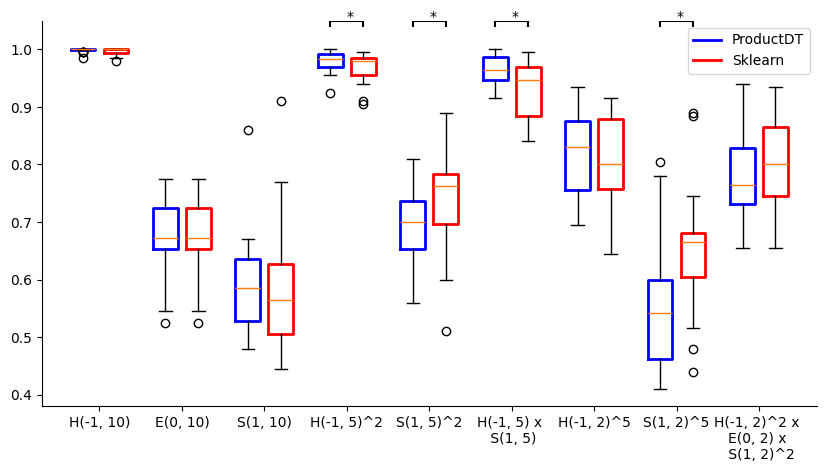

In [11]:
# Let's see the values: barplot with statistical significance annotations

from scipy.stats import ttest_rel

# psdt_means, dt_means, psdt_stds, dt_stds, p_vals = [], [], [], [], []
psdt_scores_by_curvature, dt_scores_by_curvature, p_vals = [], [], []
for sig in SIGNATURES:
    res_K = results2[[sig_r == sig for sig_r in results2["signature"]]]
    psdt_scores_by_curvature.append(res_K["psdt_acc"])
    dt_scores_by_curvature.append(res_K["dt_acc"])
    p_vals.append(ttest_rel(res_K["psdt_acc"], res_K["dt_acc"]).pvalue)


plt.figure(figsize=(10, 5))
x_vals = np.arange(len(SIGNATURES))
bp1 = plt.boxplot(
    psdt_scores_by_curvature,
    positions=x_vals - 0.2,
    widths=0.3,
    boxprops=dict(color="blue", linewidth=2),
)
bp2 = plt.boxplot(
    dt_scores_by_curvature,
    positions=x_vals + 0.2,
    widths=0.3,
    boxprops=dict(color="red", linewidth=2),
)

# Add asterisks
ymin, ymax = plt.gca().get_ylim()
for x, p_val in zip(x_vals, p_vals):
    if p_val < 0.05:
        plt.text(x, ymax + 0.02, "*", color="black")
        plt.hlines(ymax + 0.02, x - 0.2, x + 0.2, color="black")
        plt.vlines(x - 0.2, ymax + 0.01, ymax + 0.02, color="black")
        plt.vlines(x + 0.2, ymax + 0.01, ymax + 0.02, color="black")

# Fix y-lim and remove top/right spines
plt.ylim(ymin, ymax + 0.02)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Set x-ticks
plt.xticks(x_vals, SIGNATURES_STR)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["ProductDT", "Sklearn"])
plt.show()

In [19]:
# Copied from my old 'abstract benchmarks' notebook:
# https://github.com/qc2321/hyperDT/blob/41171f90d9ddac39d55f65e487963ceb6a72e05d/notebooks/abstract_benchmarks.ipynb

for (
    signature,
    signature_str,
) in zip(SIGNATURES, SIGNATURES_STR):
    row = results2[[sig_r == signature for sig_r in results2["signature"]]]
    psdt_scores = row["psdt_acc"]
    dt_scores = row["dt_acc"]
    print(signature_str)
    print(
        f"Avg PSDT Score: {np.mean(psdt_scores) * 100:.1f} +/- {np.std(psdt_scores) / np.sqrt(len(psdt_scores)) * 1.96 * 100 :.1f}",
        end=", ",
    )
    print(
        f"Avg DT Score: {np.mean(dt_scores) * 100:.1f} +/- {np.std(dt_scores) / np.sqrt(len(dt_scores)) * 1.96 * 100 :.1f}"
    )

    t, p = ttest_rel(psdt_scores, dt_scores)
    if p < 0.05:
        print("PSDT and DT are significantly different")

    # print(
    #     f"Avg PSRF Score: {np.mean(psrf_scores) * 100:.1f} +/- {np.std(psrf_scores) / np.sqrt(len(psrf_scores)) * 1.96 * 100 :.1f}",
    #     end=", ",
    # )
    # print(
    #     f"Avg RF Score: {np.mean(rf_scores) * 100:.1f} +/- {np.std(rf_scores) / np.sqrt(len(rf_scores)) * 1.96 * 100 :.1f}"
    # )

    # t, p = stats.ttest_rel(psrf_scores, rf_scores)
    # if p < 0.05:
    #     print("PSRF and RF are significantly different")
    print()

H(-1, 10)
Avg PSDT Score: 99.8 +/- 0.2, Avg DT Score: 99.6 +/- 0.3

E(0, 10)
Avg PSDT Score: 67.5 +/- 2.7, Avg DT Score: 67.5 +/- 2.7

S(1, 10)
Avg PSDT Score: 59.5 +/- 3.7, Avg DT Score: 58.5 +/- 4.9

H(-1, 5)^2
Avg PSDT Score: 97.9 +/- 0.8, Avg DT Score: 96.8 +/- 1.1
PSDT and DT are significantly different

S(1, 5)^2
Avg PSDT Score: 70.0 +/- 2.9, Avg DT Score: 73.6 +/- 4.0
PSDT and DT are significantly different

H(-1, 5) x 
 S(1, 5)
Avg PSDT Score: 96.6 +/- 1.1, Avg DT Score: 93.2 +/- 2.1
PSDT and DT are significantly different

H(-1, 2)^5
Avg PSDT Score: 82.0 +/- 3.2, Avg DT Score: 80.7 +/- 3.4

S(1, 2)^5
Avg PSDT Score: 55.5 +/- 4.5, Avg DT Score: 65.3 +/- 4.8
PSDT and DT are significantly different

H(-1, 2)^2 x 
E(0, 2) x 
 S(1, 2)^2
Avg PSDT Score: 78.1 +/- 3.0, Avg DT Score: 80.1 +/- 3.2

